In [22]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [144]:
def rotmat2d(angle):
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

def ellipse_radius(theta, a, b):
    return a * b / np.sqrt((b*np.cos(theta))**2 + (a*np.sin(theta))**2)

def tangencial_vector(theta, a, b, angle=0):
    e = np.sqrt(1 - (b/a)**2)
    # theta = 2*np.arctan2(np.tan(-E/2), np.sqrt((1-e)/(1+e)))
    E = np.arccos((e + np.cos(theta)) / (1 + e * np.cos(theta)))
    if theta > np.pi:
        E = -E
    return rotmat2d(angle) @ np.array([
        -a * np.sin(E),
        b * np.cos(E)
    ]) / np.sqrt(b**2 * np.cos(E)**2 + a**2 * np.sin(E)**2)
    
def orbit_equation(theta, a, e):
    return a * (1 - e**2) / (1 + e * np.cos(theta))

def compute_angle(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    cosine_angle = dot_product / norm_product
    angle = np.arccos(cosine_angle)
    return angle

In [145]:
def plot_ellipse(plt, center, a, b, angle, n_points=100, angle_start=0, angle_finish=2*np.pi):
    theta = np.linspace(angle_start, angle_finish, n_points)
    x = center[0] + a * np.cos(theta) * np.cos(angle) - b * np.sin(theta) * np.sin(angle)
    y = center[1] + a * np.cos(theta) * np.sin(angle) + b * np.sin(theta) * np.cos(angle)
    return plt.plot(x, y)

def on_ellipse(theta, focus, a, b):
    r = orbit_equation(theta, a, np.sqrt(1 - (b/a)**2))
    return focus + r * np.array([np.cos(theta), np.sin(theta)])

def radial_vector(theta, a, b, angle):
    focus = rotmat2d(angle) @ np.array([np.sqrt(a**2 - b**2), 0])
    v = on_ellipse(theta, focus, a, b) - focus
    norm = np.linalg.norm(v)
    return v / norm

def flight_path_angle(v, position, focus):
    r = position - focus
    return np.pi/2 - np.arctan2(np.cross(r, v), np.dot(r, v))

In [146]:
def velocity_at(theta, a, b, mu, angle=0, vector=True):
    v = np.sqrt(mu * (2 / orbit_equation(theta, a, np.sqrt(1 - (b/a)**2)) - 1 / a))
    if vector:
        return tangencial_vector(theta, a, b, angle) * v
    return v

In [147]:
a = 2
b = 1
mu = .2
angle = 0
center = np.array([0, 0])
focus = center + rotmat2d(angle) @ np.array([np.sqrt(a**2 - b**2), 0])
e = np.sqrt(1 - (b/a)**2)

theta = 3*np.pi/4

a = 2, a' = 1.8579423469852387
e = 0.8660254037844386, e' = 0.8549181734347229
θ = 2.356194490192345, θ' = 2.3692725354915174
γ = 56.98539116104856º


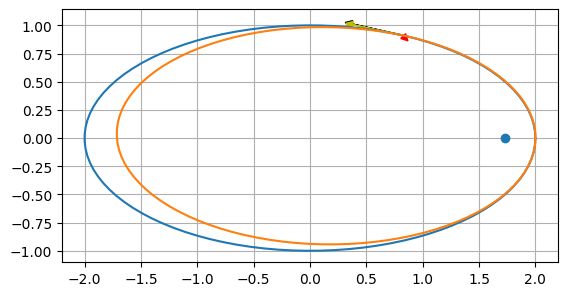

In [160]:
r = orbit_equation(theta, a, e)
e_r = on_ellipse(theta, focus, a, b) - focus
e_r /= np.linalg.norm(e_r)

vi = velocity_at(theta, a, b, mu, angle)
delta_v = e_r * -0.01
vf = vi + delta_v

vf_sq = np.sum(np.square(vf))
rv2m = r * vf_sq / mu
fpa = flight_path_angle(vf, on_ellipse(theta, focus, a, b), focus)
new_a = r / (2 - rv2m)
new_e = np.sqrt((rv2m - 1)**2 * np.cos(fpa)**2 + np.sin(fpa)**2)
new_b = new_a * np.sqrt(1 - new_e**2)
new_c = np.sqrt(new_a**2 - new_b**2)
new_theta = np.arctan2(rv2m * np.sin(fpa) * np.cos(fpa), rv2m * np.cos(fpa)**2 - 1)
rot = theta - new_theta
new_angle = angle + rot
print(f"{a = }, a' = {new_a}")
print(f"{e = }, e' = {new_e}")
print(f"θ = {theta}, θ' = {new_theta}")
print(f"\u03b3 = {np.degrees(fpa)}º")

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.grid()
ax.set_axisbelow(True)

start = on_ellipse(theta, focus, a, b)
w = .0015
ax.arrow(*start, *vi, width=w, head_width=w*40, head_length=w*40, color="k")
ax.arrow(*start, *delta_v, width=w, head_width=w*40, head_length=w*40, color="r")
ax.arrow(*start, *vf, width=w, head_width=w*40, head_length=w*40, color="y")

er = on_ellipse(theta, focus, a, b) - focus
# er = er / np.linalg.norm(er)
# et = np.array([-er[1], er[0]])
# et = et / np.linalg.norm(et)
# ax.arrow(*focus, *er, width=w, head_width=w*40, head_length=w*40, color="k")
# ax.arrow(*start, *et, width=w, head_width=w*40, head_length=w*40, color="k")

# Draw initial ellipse
plot_ellipse(ax, center, a, b, angle)
# Draw new ellipse
plot_ellipse(ax, focus - new_c * np.array([np.cos(new_angle), np.sin(new_angle)]), new_a, new_b, new_angle)
plt.scatter(*focus)

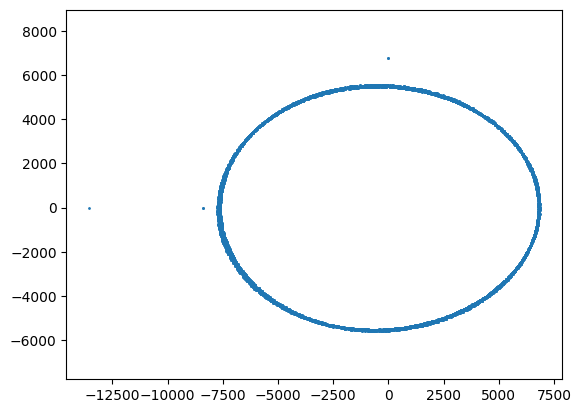

In [176]:
h = .01
mu = 3.986e5
r = [6378 + 400]
angle = [0]
theta = [0]
a = [r[0]]
b = [r[0]]
e = [1]
v = [velocity_at(theta[-1], a[-1], b[-1], mu, angle[-1])]
center = np.array([0, 0])
focus = center + rotmat2d(angle[-1]) @ np.array([np.sqrt(a[-1]**2 - b[-1]**2), 0])
points = []

for i in range(5000):
    e_r = on_ellipse(theta[-1], focus, a[-1], b[-1]) - focus
    e_r /= np.linalg.norm(e_r)

    vi = velocity_at(theta[-1], a[-1], b[-1], mu, angle[-1])
    delta_v = e_r * 0.005 * h
    vf = vi + delta_v
    v.append(vf)

    vf_sq = np.sum(np.square(vf))
    rv2m = r[-1] * vf_sq / mu
    fpa = flight_path_angle(vf, on_ellipse(theta[-1], focus, a[-1], b[-1]), focus)
    new_a = r[-1] / (2 - rv2m)
    new_e = np.sqrt((rv2m - 1)**2 * np.cos(fpa)**2 + np.sin(fpa)**2)
    new_b = new_a * np.sqrt(1 - new_e**2)
    # new_c = np.sqrt(new_a**2 - new_b**2)
    new_theta = np.arctan2(rv2m * np.sin(fpa) * np.cos(fpa), rv2m * np.cos(fpa)**2 - 1)
    rot = theta[-1] - new_theta
    new_angle = angle[-1] + rot
    a.append(new_a)
    e.append(new_e)
    b.append(new_b)
    angle.append(new_angle)
    theta.append(new_theta)
    focus = center + rotmat2d(angle[-1]) @ np.array([np.sqrt(a[-1]**2 - b[-1]**2), 0])
    points.append(on_ellipse(theta[-1], focus, a[-1], b[-1]))
    
    # Update again
    theta.append(theta[-1] + h * np.sqrt(mu / a[-1]**3))
    r.append(orbit_equation(theta[-1], a[-1], e[-1]))
    points.append(on_ellipse(theta[-1], focus, a[-1], b[-1]))
    
plt.axis("equal")    
plt.scatter([x for x, y in points], [y for x, y in points], s=1)